# DATA LOADING AND PREPROCESSING

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126


Counting the no of files in each folder for picking labels with large dataset

In [2]:
import os

# Function to count files in each class directory
def count_files_per_class(parent_directory):
    class_counts = {}
    # Iterate through each subdirectory (class)
    for class_name in os.listdir(parent_directory):
        class_path = os.path.join(parent_directory, class_name)
        if os.path.isdir(class_path):  # Ensure it's a directory
            # Count files in this class directory
            num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_files
    return class_counts

# Function to sort the classes by file count
def sort_class_counts(class_counts):
    return sorted(class_counts.items(), key=lambda x: x[1])  # Sort by the count (value)

train_dir = r"data\train"  



train_class_counts = count_files_per_class(train_dir)


sorted_train_counts = sort_class_counts(train_class_counts)

# Display sorted counts for each directory
print("Sorted file counts in 'train' directory by class (ascending):")
for class_name, count in sorted_train_counts:
    print(f"  {class_name}: {count} files")

Sorted file counts in 'train' directory by class (ascending):
  BreastStroke: 75 files
  PlayingViolin: 75 files
  PullUps: 75 files
  Skijet: 75 files
  TaiChi: 75 files
  PushUps: 76 files
  PlayingPiano: 78 files
  UnevenBars: 78 files
  BalanceBeam: 81 files
  BlowingCandles: 81 files
  CuttingInKitchen: 82 files
  MoppingFloor: 82 files
  SkyDiving: 82 files
  Fencing: 83 files
  HandstandWalking: 83 files
  PlayingTabla: 83 files
  Rafting: 83 files
  BodyWeightSquats: 84 files
  CleanAndJerk: 84 files
  PizzaTossing: 84 files
  StillRings: 84 files
  ApplyLipstick: 85 files
  ParallelBars: 85 files
  JavelinThrow: 87 files
  SumoWrestling: 87 files
  VolleyballSpiking: 87 files
  RopeClimbing: 89 files
  TrampolineJumping: 89 files
  JugglingBalls: 90 files
  SkateBoarding: 90 files
  HighJump: 92 files
  JumpingJack: 92 files
  Knitting: 92 files
  PommelHorse: 92 files
  WalkingWithDog: 92 files
  FloorGymnastics: 93 files
  HorseRace: 93 files
  HulaHoop: 93 files
  MilitaryP

Extracting frames and storing it in Tensor and Numpy format for storage

In [3]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms

class UCF101Dataset(Dataset):
    def __init__(self, csv_path, clip_len=16, transform=None):

        self.data = pd.read_csv(csv_path)
        self.clip_len = clip_len
        self.transform = transform
        selected_labels = ['PlayingCello','PlayingDhol','TennisSwing','CricketShot','HorseRiding']
        self.data = self.data[self.data['label'].isin(selected_labels)]

        '''Only include 5 classes
        selected_labels = sorted(self.data['label'].unique())[:5]  # or specify manually
        self.data = self.data[self.data['label'].isin(selected_labels)]'''

        '''Ensure the dataset is balanced by sampling 5 clips per label
        self.data = self.data.groupby('label', group_keys=False).apply(lambda x: x.sample(n=5, random_state=42)).reset_index(drop=True)'''

       
        
        # Build label-to-index mapping from unique labels
        self.label2index = {label: idx for idx, label in enumerate(sorted(self.data['label'].unique()))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        root_dir = r"C:\Users\Swapn\Downloads\Intern\Projects\c3d\data"
        video_rel_path = self.data.iloc[idx]['clip_path']
        video_path = os.path.join(root_dir, video_rel_path)

        label_str = self.data.iloc[idx]['label']
        label_idx = self.label2index[label_str]  # Convert label string to integer

        frames = self.load_video(video_path)

        if self.transform:
            frames = self.transform(frames)

        return frames, label_idx  # Return label as integer

    def load_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (112, 112))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        cap.release()

        #Video format is not Readable
        if len(frames) == 0:
            frames = [np.zeros((112, 112, 3), dtype=np.uint8).copy() for _ in range(self.clip_len)]
        #If the clips to shoty copy the previous frame
        elif len(frames) < self.clip_len:
            last_frame = frames[-1]
            frames.extend([last_frame.copy() for _ in range(self.clip_len - len(frames))])
        # If the video is too long truncate 
        else:
            frames = frames[:self.clip_len] 

        frames = np.array(frames).astype(np.float32) / 255.0  
        frames = frames.transpose(3, 0, 1, 2)  

        return torch.from_numpy(frames)

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Define the path to your CSV file
csv_path1 = r"C:\Users\Swapn\Downloads\Intern\Projects\c3d\data\train.csv"

csv_path2 = r"C:\Users\Swapn\Downloads\Intern\Projects\c3d\data\val.csv"

transform = transforms.Compose([
    # Add other transformations if needed (like normalization)
])

# Instantiate the dataset
dataset1 = UCF101Dataset(csv_path=csv_path1, clip_len=16, transform=transform)
dataset2 = UCF101Dataset(csv_path=csv_path2, clip_len=16, transform=transform)

# Create a DataLoader (optional, for batching)
train_loader = DataLoader(dataset1, batch_size=5, shuffle=True)
val_loader = DataLoader(dataset2, batch_size=5, shuffle=True)

for i, (frames, label) in enumerate(train_loader):
    print(f"Batch of train {i+1}")
    print(f"Frames shape: {frames.shape}")  
    print(f"Label: {label}")


    print(f"First frame shape: {frames[0, :, 0, :, :].shape}")  
    if i == 0:  
        break
for i, (frames, label) in enumerate(val_loader):
    print(f"Batch of val {i+1}")
    print(f"Frames shape: {frames.shape}")  
    print(f"Label: {label}")


    print(f"First frame shape: {frames[0, :, 0, :, :].shape}")  
    if i == 0:  
        break

Batch of train 1
Frames shape: torch.Size([5, 3, 16, 112, 112])
Label: tensor([4, 1, 4, 0, 0])
First frame shape: torch.Size([3, 112, 112])
Batch of val 1
Frames shape: torch.Size([5, 3, 16, 112, 112])
Label: tensor([3, 3, 4, 0, 3])
First frame shape: torch.Size([3, 112, 112])


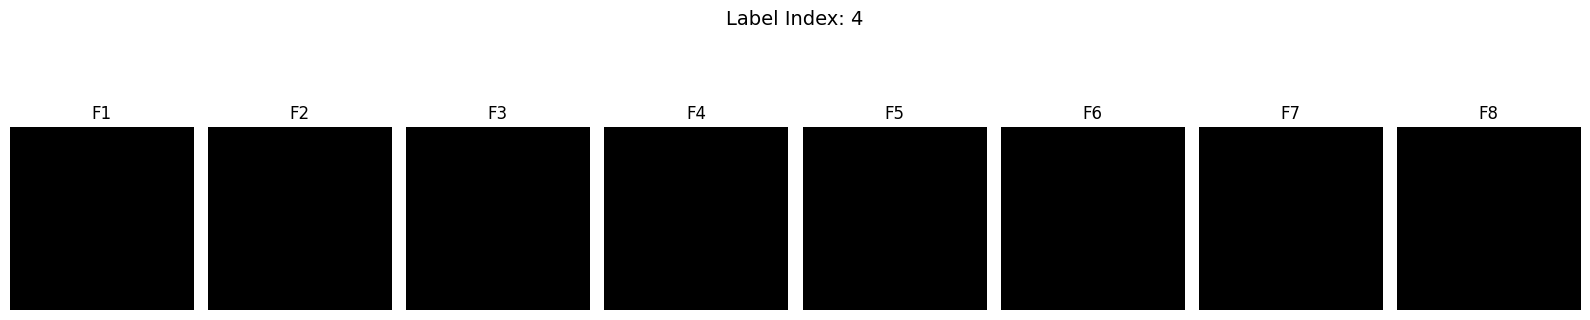

In [13]:
import matplotlib.pyplot as plt

# Initialize your dataset
dataset = UCF101Dataset(
    csv_path=r'C:\Users\Swapn\Downloads\Intern\Projects\c3d\data\train.csv',  # 👈 put your actual CSV file path here
    clip_len=16,
    transform=None
)

# Get one clip from the dataset
frames, label = dataset[i]  

# Convert frames from [C, T, H, W] → [T, H, W, C] for plotting
frames_np = frames.permute(1, 2, 3, 0).numpy()  # shape: [T, H, W, C]

# Plot the first few frames
num_frames_to_show = min(8, frames_np.shape[0])
plt.figure(figsize=(16, 4))
for i in range(num_frames_to_show):
    plt.subplot(1, num_frames_to_show, i + 1)
    plt.imshow(frames_np[i])
    plt.axis('off')
    plt.title(f"F{i+1}")

plt.suptitle(f"Label Index: {label}", fontsize=14)
plt.tight_layout()
plt.show()


In [6]:
'''import torch
import torch.nn as nn

class C3DHybridSVM(nn.Module):
    def __init__(self, num_classes):
        super(C3DHybridSVM, self).__init__()

        # C3D convolutional layers
        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

        # Fully connected layers for feature extraction
        self.fc6 = nn.Linear(8192, 4096)
        self.fc7 = nn.Linear(4096, 4096)

        # Linear SVM layer (replacing fc8)
        self.svm_linear = nn.Linear(4096, num_classes)

        # Other components
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        # C3D feature extraction
        h = self.relu(self.conv1(x))
        h = self.pool1(h)

        h = self.relu(self.conv2(h))
        h = self.pool2(h)

        h = self.relu(self.conv3a(h))
        h = self.relu(self.conv3b(h))
        h = self.pool3(h)

        h = self.relu(self.conv4a(h))
        h = self.relu(self.conv4b(h))
        h = self.pool4(h)

        h = self.relu(self.conv5a(h))
        h = self.relu(self.conv5b(h))
        h = self.pool5(h)

        h = h.view(-1, 8192)
        h = self.relu(self.fc6(h))
        h = self.dropout(h)
        h = self.relu(self.fc7(h))
        h = self.dropout(h)

        # SVM linear layer (outputs raw scores)
        scores = self.svm_linear(h)

        return scores

    def get_features(self, x):
        """Extract features from the fc7 layer for external SVM training."""
        h = self.relu(self.conv1(x))
        h = self.pool1(h)

        h = self.relu(self.conv2(h))
        h = self.pool2(h)

        h = self.relu(self.conv3a(h))
        h = self.relu(self.conv3b(h))
        h = self.pool3(h)

        h = self.relu(self.conv4a(h))
        h = self.relu(self.conv4b(h))
        h = self.pool4(h)

        h = self.relu(self.conv5a(h))
        h = self.relu(self.conv5b(h))
        h = self.pool5(h)

        h = h.view(-1, 8192)
        h = self.relu(self.fc6(h))
        h = self.dropout(h)
        h = self.relu(self.fc7(h))
        return h'''

'import torch\nimport torch.nn as nn\n\nclass C3DHybridSVM(nn.Module):\n    def __init__(self, num_classes):\n        super(C3DHybridSVM, self).__init__()\n\n        # C3D convolutional layers\n        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))\n        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))\n\n        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))\n        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))\n\n        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))\n        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))\n        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))\n\n        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))\n        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))\n        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 

In [7]:
#Model without SVM and Validation function
import torch
import torch.nn as nn

class C3D(nn.Module):
    def __init__(self, num_classes=101):
        super(C3D, self).__init__()

        self.features = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),

            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),

            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),

            nn.Conv3d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),

            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        )

        # Dynamically determine the flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 16, 112, 112)
            dummy_output = self.features(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [16]:
if 'labels' not in locals():
	for i, (frames, labels) in enumerate(train_loader):
		break  

print(type(labels), labels)

if 'labels' not in locals():
	for i, (frames, labels) in enumerate(val_loader):
		break  

print(type(labels), labels)


<class 'torch.Tensor'> tensor([2, 2, 3, 3, 1])
<class 'torch.Tensor'> tensor([2, 2, 3, 3, 1])


In [9]:

if 'frames' not in locals():
	for i, (frames, label) in enumerate(train_loader):
		break  

print("Input to model:", frames.shape)

Input to model: torch.Size([5, 3, 16, 112, 112])


In [10]:
def hinge_loss(outputs, targets, margin=1.0):
    """Multi-class hinge loss (SVM-style)."""
    batch_size = outputs.size(0)
    correct_class_scores = outputs[range(batch_size), targets].view(-1, 1)
    margins = torch.clamp(outputs - correct_class_scores + margin, min=0)
    margins[range(batch_size), targets] = 0  # zero out the correct class
    return margins.sum() / batch_size


In [11]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA available: True
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4050 Laptop GPU


In [12]:
import torch.optim as optim
from tqdm import tqdm

# Define device - this line was incomplete and duplicated
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model and optimizer
model = C3DHybridSVM(num_classes=5).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 50

# Ensure data_loader is defined
if 'train_loader' not in locals():
    raise NameError("train_loader is not defined. Please execute the cell defining data_loader before running this cell.")

if 'val_loader' not in locals():
    raise NameError("val_loader is not defined. Please execute the cell defining data_loader before running this cell.")

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    loop1 = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    
    for frames, labels in loop1:
        frames = frames.to(device)
        labels = labels.to(device, dtype=torch.long)
        
        # Forward pass
        outputs = model(frames)
        loss = hinge_loss(outputs, labels, margin=1.0)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        loop1.set_postfix(loss=loss.item(), acc=100 * correct / total)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader):.4f} Accuracy: {100 * correct / total:.2f}%")
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    loop2 = tqdm(val_loader, desc="Validation", leave=False)
    
    with torch.no_grad():
        for frames, labels in loop2:
            frames, labels = frames.to(device), labels.to(device, dtype=torch.long)
            outputs = model(frames)
            val_loss += hinge_loss(outputs, labels, margin=1.0).item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Update progress bar with current stats
            loop2.set_postfix(loss=val_loss/(loop2.n+1), acc=100 * val_correct / val_total)
    
    # Fixed the print statement (removed the trailing parenthesis)
    print(f"Validation Loss: {val_loss/len(val_loader):.4f} Accuracy: {100 * val_correct / val_total:.2f}%")

NameError: name 'C3DHybridSVM' is not defined

In [ ]:
#training loop without val and SVM
'''import torch.optim as optim
from tqdm import tqdm

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model, loss, and optimizer
model = C3DHybridSVM(num_classes=101).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 50

# Ensure data_loader is defined
if 'data_loader1' not in locals():
    raise NameError("data_loader1 is not defined. Please execute the cell defining data_loader before running this cell.")

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(data_loader1, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

    for frames, labels in loop:
        frames = frames.to(device)
        labels = labels.to(device, dtype=torch.long)  # Now safe to use directly

        # Forward pass
        outputs = model(frames)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(data_loader1):.4f} Accuracy: {100 * correct / total:.2f}%")'''


'import torch.optim as optim\nfrom tqdm import tqdm\n\n# Set device (use GPU if available)\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\n# Instantiate model, loss, and optimizer\nmodel = C3DHybridSVM(num_classes=101).to(device)\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.parameters(), lr=0.001)\n\n# Training parameters\nnum_epochs = 50\n\n# Ensure data_loader is defined\nif \'data_loader1\' not in locals():\n    raise NameError("data_loader1 is not defined. Please execute the cell defining data_loader before running this cell.")\n\n# Training loop\nfor epoch in range(num_epochs):\n    model.train()\n    running_loss = 0.0\n    correct = 0\n    total = 0\n\n    loop = tqdm(data_loader1, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)\n\n    for frames, labels in loop:\n        frames = frames.to(device)\n        labels = labels.to(device, dtype=torch.long)  # Now safe to use directly\n\n        # Forward pass\n        outputs = model

In [ ]:
#For Creating an output video with predictions
'''import cv2
import numpy as np
import torch

# Load model
model = C3D(num_classes=5)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Label mapping
index2label = {
    0: 'PlayingCello',
    1: 'PlayingDhol',
    2: 'TennisSwing',
    3: 'CricketShot',
    4: 'Basketball'
}

# Video path
video_path = r"data/test/TennisSwing/v_TennisSwing_g05_c03.avi"
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video writer
out = cv2.VideoWriter('output.avi',
                      cv2.VideoWriter_fourcc(*'XVID'),
                      fps, (width, height))

# Parameters
clip_len = 16
frames_buffer = []
label = "..."  # Default label before prediction

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    resized = cv2.resize(frame, (112, 112))
    rgb_frame = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    frames_buffer.append(rgb_frame)

    if len(frames_buffer) == clip_len:
        clip = np.array(frames_buffer).astype(np.float32) / 255.0
        clip = clip.transpose(3, 0, 1, 2)
        input_tensor = torch.tensor(clip).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)
            label = index2label.get(predicted.item(), "Unknown")

        frames_buffer.clear()  # Reset for next clip

    # Overlay label on frame
    cv2.putText(frame, f"Prediction: {label}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    out.write(frame)  # Write frame with label

cap.release()
out.release()
cv2.destroyAllWindows()

print("Video saved as 'output.avi'")'''


Video saved as 'output.avi'


In [ ]:
import cv2
import numpy as np
import torch
import threading
import time

# Your model
model = C3DHybridSVM(num_classes=5)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Label mapping
index2label = {
    0: 'PlayingCello',
    1: 'PlayingDhol',
    2: 'TennisSwing',
    3: 'CricketShot',
    4: 'Basketball'
}

# Globals for threading
latest_prediction = "Loading..."
frames_buffer = []
clip_len = 16
lock = threading.Lock()

# Prediction function in background
def predict_clip(buffer):
    global latest_prediction
    clip = np.array(buffer).astype(np.float32) / 255.0
    clip = clip.transpose(3, 0, 1, 2)
    input_tensor = torch.tensor(clip).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        with lock:
            latest_prediction = index2label.get(predicted.item(), "Unknown")

# Open video
video_path = r"C:\Users\Swapn\Downloads\Intern\Projects\c3d\data\test\Basketball\v_BasketballDunk_g22_c02.avi"
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
delay = 1.0 / fps if fps > 0 else 0.04

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Display resized frame
    display_frame = frame.copy()
    cv2.putText(display_frame, f"Prediction: {latest_prediction}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    cv2.imshow("Video Classification", display_frame)

    # Prepare input for model (downsampled)
    resized = cv2.resize(frame, (112, 112))
    rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    frames_buffer.append(rgb)

    if len(frames_buffer) == clip_len:
        # Predict in background
        buffer_copy = frames_buffer.copy()
        threading.Thread(target=predict_clip, args=(buffer_copy,), daemon=True).start()
        frames_buffer.pop(0)  # Slide window

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    time.sleep(delay)

cap.release()
cv2.destroyAllWindows()
